In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

In [11]:
transaction_data = pd.read_csv(r'C:\Users\alons\retailer_mb\Market Basket Analysis.csv')

transaction_data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
transaction_data['Date'] = pd.to_datetime(transaction_data['Date'])
transaction_data['month'] = transaction_data['Date'].dt.month
print(transaction_data.head())

   BillNo                             Itemname  Quantity                Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   
1  536365                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   
2  536365       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   

   Price  CustomerID         Country  month  
0   2.55     17850.0  United Kingdom     12  
1   3.39     17850.0  United Kingdom     12  
2   2.75     17850.0  United Kingdom     12  
3   3.39     17850.0  United Kingdom     12  
4   3.39     17850.0  United Kingdom     12  


In [13]:
transaction_data.dtypes

BillNo                 int64
Itemname              object
Quantity               int64
Date          datetime64[ns]
Price                float64
CustomerID           float64
Country               object
month                  int32
dtype: object

In [14]:
transaction_data.isnull().sum()

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134038
Country            0
month              0
dtype: int64

In [15]:
transaction_data.dropna(subset=['Itemname'], inplace=True)
transaction_data.isnull().sum()

BillNo             0
Itemname           0
Quantity           0
Date               0
Price              0
CustomerID    132583
Country            0
month              0
dtype: int64

In [16]:
#makes non account holders 0 value in 'customerid'
transaction_data['CustomerID'].fillna(0, inplace=True)

# Converts those with customerid and account holders to a 1 value
transaction_data['CustomerID'] = transaction_data['CustomerID'].apply(lambda x: 1 if x != 0 else 0)

transaction_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
Country       0
month         0
dtype: int64

In [17]:
transaction_data['Total'] = transaction_data['Quantity'] * transaction_data['Price']
transaction_data[:5]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,month,Total
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,1,United Kingdom,12,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,1,United Kingdom,12,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,1,United Kingdom,12,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,1,United Kingdom,12,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,1,United Kingdom,12,20.34


In [18]:
#Retrieve Only Aprils data
april_data=transaction_data[transaction_data['Date'].dt.month ==4]
print(april_data)

        BillNo                          Itemname  Quantity  \
137063  548550       LUNCH BAG DOLLY GIRL DESIGN        10   
137064  548550         HEART IVORY TRELLIS LARGE        12   
137065  548550                VINTAGE SNAP CARDS        12   
137066  548550    BOX OF VINTAGE ALPHABET BLOCKS         2   
137067  548550       PAPERWEIGHT VINTAGE COLLAGE         6   
...        ...                               ...       ...   
166049  551507   PLASTERS IN TIN VINTAGE PAISLEY        12   
166050  551507  PLASTERS IN TIN WOODLAND ANIMALS        12   
166051  551514         GOLD FLOWER CUSHION COVER         6   
166052  551514                 VIPPASSPORT COVER         3   
166053  551514          VINTAGE UNION JACK APRON        11   

                      Date  Price  CustomerID         Country  month  Total  
137063 2011-04-01 08:22:00   1.65           1  United Kingdom      4  16.50  
137064 2011-04-01 08:22:00   1.65           1  United Kingdom      4  19.80  
137065 2011-04-01 08:

In [19]:
#Aprils items exploration
unique_item_count = april_data['Itemname'].nunique()
print("total unique items sold:", unique_item_count)

total unique items sold: 2435


In [20]:
items_count= april_data['Itemname'].value_counts()
print(items_count)

Itemname
PARTY BUNTING                         192
WHITE HANGING HEART T-LIGHT HOLDER    181
REGENCY CAKESTAND 3 TIER              175
PAPER CHAIN KIT EMPIRE                159
PACK OF 72 RETROSPOT CAKE CASES       124
                                     ... 
TOP SECRET PEN SET                      1
SMALL LICORICE DES PINK BOWL            1
SMALL HANGING GLASS+ZINC LANTERN        1
CHRISTMAS RETROSPOT ANGEL WOOD          1
ASS DES PHONE SPONGE CRAFT STICKER      1
Name: count, Length: 2435, dtype: int64


In [21]:
april_data['Price'].describe()

count    28765.000000
mean         3.962486
std         25.527909
min          0.000000
25%          1.250000
50%          2.080000
75%          4.130000
max       2382.920000
Name: Price, dtype: float64

In [22]:
#Basket Value Distribution 
basket_total= april_data.groupby('BillNo')['Total'].sum()
basket_total[:5]

BillNo
548550    244.79
548551    364.80
548552    239.75
548553    138.75
548554    888.20
Name: Total, dtype: float64

In [23]:
basket_total.describe()

count     1261.000000
mean       418.766694
std        769.817855
min          0.000000
25%        142.520000
50%        294.040000
75%        453.000000
max      21535.900000
Name: Total, dtype: float64

In [24]:
zero_total_baskets_count = (basket_total == 0).sum()
print(zero_total_baskets_count)


32


In [25]:
entries_with_zero_total = april_data[april_data['Total'] == 0]
print(entries_with_zero_total)

        BillNo                             Itemname  Quantity  \
137598  548620                              Damaged       -32   
140026  548871          HEART GARLAND RUSTIC PADDED         2   
141371  548999                              damages       -26   
141999  549100          CHICK GREY HOT WATER BOTTLE         1   
144983  549427                              damages       -12   
145656  549527     mystery! Only ever imported 1800     -1479   
145658  549529   MERCHANT CHANDLER CREDIT ERROR STO      -576   
145659  549531            POSSIBLE DAMAGES OR LOST?      -750   
148589  549846                              Damaged        -6   
149090  549935                              damaged       -43   
149231  549948                              damaged        -1   
149267  549950                              Damaged        -6   
149292  549952                              Damaged       -93   
151016  550153                              DAMAGED        -1   
151404  550188   CHILDS B

In [26]:
#Basket Size Distribution
basket_size=april_data.groupby('BillNo')['Quantity'].sum()
basket_size[:5]

BillNo
548550     109
548551     160
548552      71
548553      88
548554    1420
Name: Quantity, dtype: int64

In [27]:
basket_size.describe()

count    1261.000000
mean      239.149088
std       488.088526
min     -1479.000000
25%        66.000000
50%       130.000000
75%       269.000000
max      9014.000000
Name: Quantity, dtype: float64

In [28]:
#Combined data into baskets
basket = (april_data.groupby(['BillNo', 'Itemname'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('BillNo'))
basket[:]

Itemname,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,...,adjustment,crushed,damaged,damages,did a credit and did not tick ret,found,mystery! Only ever imported 1800,returned,wrong code,wrong code?
BillNo,,,,,,,,,,,,,,,,,,,,,
548550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551471,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
items_frequency= items_count/len(basket)
items_frequency[:11]

Itemname
PARTY BUNTING                         0.152260
WHITE HANGING HEART T-LIGHT HOLDER    0.143537
REGENCY CAKESTAND 3 TIER              0.138779
PAPER CHAIN KIT EMPIRE                0.126090
PACK OF 72 RETROSPOT CAKE CASES       0.098335
JUMBO BAG RED RETROSPOT               0.096749
ASSORTED COLOUR BIRD ORNAMENT         0.095163
LUNCH BAG RED RETROSPOT               0.087232
SET OF 4 PANTRY JELLY MOULDS          0.085646
WOODEN UNION JACK BUNTING             0.085646
PAPER BUNTING RETROSPOT               0.076923
Name: count, dtype: float64

C:\Users\alons\AppData\Local\Temp\ipykernel_14324\1967846615.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


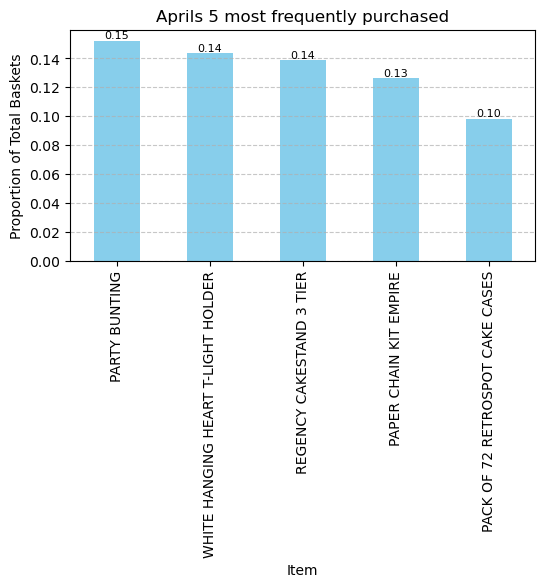

In [30]:
plt.figure(figsize=(6, 3))
ax = items_frequency[:5].plot(kind='bar', color='skyblue', width=0.5)
plt.title('Aprils 5 most frequently purchased')
plt.xlabel('Item')
plt.ylabel('Proportion of Total Baskets')
plt.xticks(rotation=90)

for i, v in enumerate(items_frequency[:5]):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

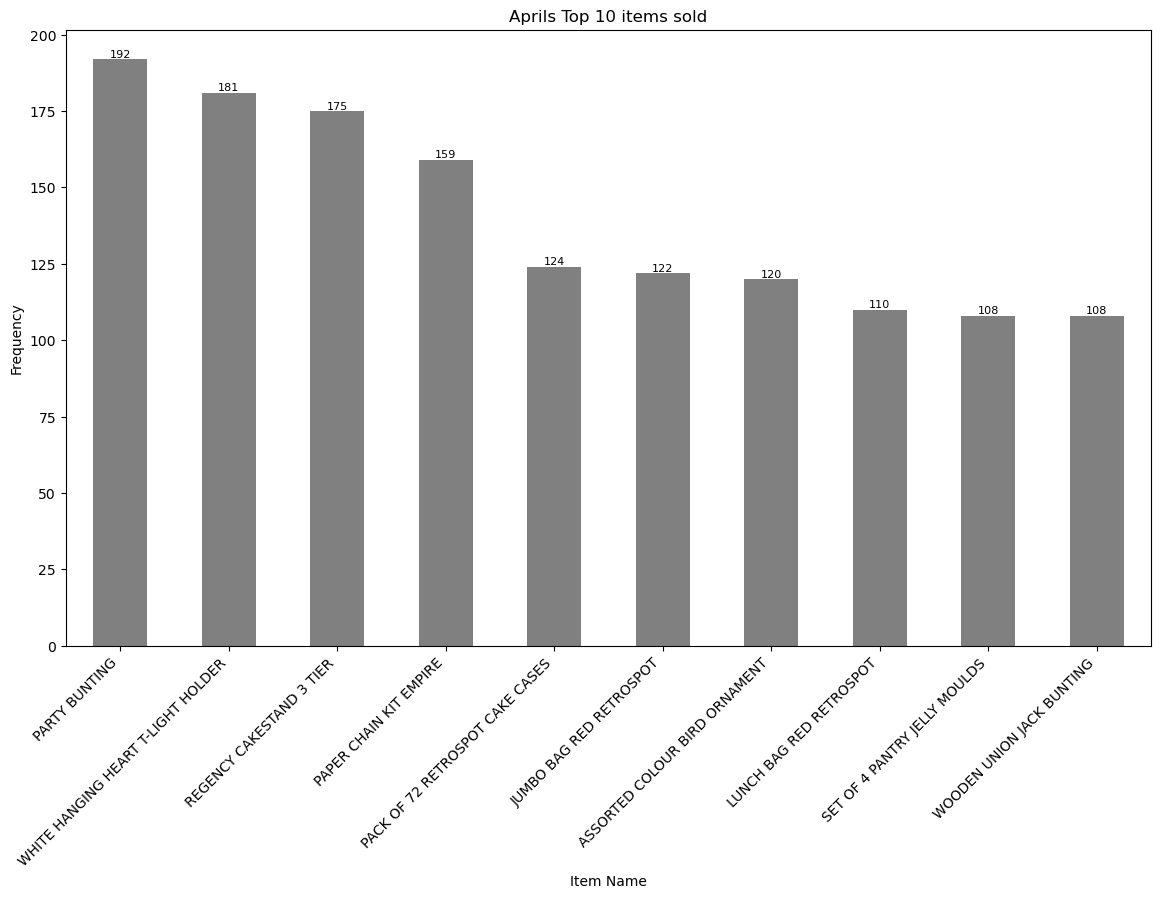

In [31]:
plt.figure(figsize=(14, 8))
top_items = april_data['Itemname'].value_counts().head(10)
top_items.plot(kind='bar', color='grey')
plt.title('Aprils Top 10 items sold')
plt.xlabel('Item Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

for i, freq in enumerate(top_items):
    plt.text(i, freq, str(freq), ha='center', va='bottom', fontsize=8)

plt.show()

In [32]:
#Tells us if the item was purchased or not making it the values binary
basket_sets = basket.apply(lambda x: x > 0, axis=1)

basket_sets

Itemname,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,...,adjustment,crushed,damaged,damages,did a credit and did not tick ret,found,mystery! Only ever imported 1800,returned,wrong code,wrong code?
BillNo,,,,,,,,,,,,,,,,,,,,,
548550,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
548551,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
548552,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
548553,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
548554,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551471,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
551501,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
551506,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
# set parameters
min_support= .03
min_confidence = .5
max_length = 2

In [34]:
# Generate frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=min_support,  use_colnames=True)
print(frequent_itemsets)

      support                                           itemsets
0    0.042030                           (6 RIBBONS RUSTIC CHARM)
1    0.065028                      (60 TEATIME FAIRY CAKE CASES)
2    0.031721                      (ALARM CLOCK BAKELIKE ORANGE)
3    0.036479                        (ALARM CLOCK BAKELIKE PINK)
4    0.052339                         (ALARM CLOCK BAKELIKE RED)
..        ...                                                ...
169  0.030135  (STRAWBERRY CHARLOTTE BAG, RED RETROSPOT CHARL...
170  0.041237  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...
171  0.045202  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...
172  0.031721  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...
173  0.030928  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...

[174 rows x 2 columns]


In [35]:
# Generate association rules
selected_columns = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)[selected_columns]
rules[:20]

,antecedents,consequents,support,confidence,lift
0,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041237,0.634146,6.719820
1,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.049960,0.851351,12.630048
2,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.049960,0.741176,12.630048
3,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.035686,0.529412,3.836714
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.054718,0.775281,11.501520
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.054718,0.811765,11.501520
6,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.030928,0.639344,6.662918
7,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.041237,0.650000,6.773967
8,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG PINK POLKADOT),0.030135,0.567164,8.939925
9,(JUMBO BAG PINK POLKADOT),(JUMBO STORAGE BAG SUKI),0.034893,0.550000,8.457927


In [36]:
#Combining antecdents and consequents into identifiable itemset pairings
rules['itemsets'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x))) + ' -> ' + rules['consequents'].apply(lambda x: ', '.join(map(str, x)))


In [37]:
#rules sorted by support
rules.sort_values(by="support", ascending= False)[:11]

,antecedents,consequents,support,confidence,lift,itemsets
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.054718,0.775281,11.501520,ROSES REGENCY TEACUP AND SAUCER -> GREEN REGEN...
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.054718,0.811765,11.501520,GREEN REGENCY TEACUP AND SAUCER -> ROSES REGEN...
21,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.052339,0.891892,12.636805,PINK REGENCY TEACUP AND SAUCER -> ROSES REGENC...
20,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.052339,0.741573,12.636805,ROSES REGENCY TEACUP AND SAUCER -> PINK REGENC...
1,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.049960,0.851351,12.630048,PINK REGENCY TEACUP AND SAUCER -> GREEN REGENC...
2,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.049960,0.741176,12.630048,GREEN REGENCY TEACUP AND SAUCER -> PINK REGENC...
28,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.045202,0.770270,14.076968,PINK REGENCY TEACUP AND SAUCER -> ROSES REGENC...
25,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.045202,0.863636,12.812299,"ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY ..."
26,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.045202,0.904762,12.819155,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ..."
27,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.045202,0.826087,14.076968,"ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY..."


C:\Users\alons\AppData\Local\Temp\ipykernel_14324\617196571.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


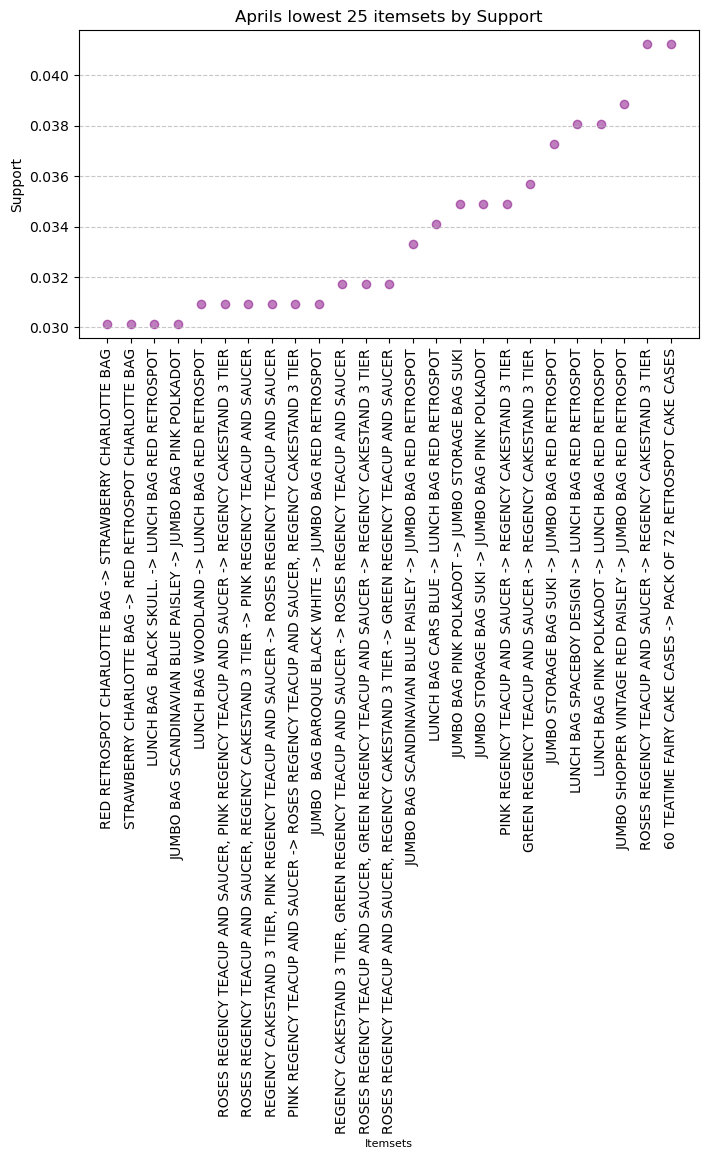

In [38]:
lowest_25_rules = rules.sort_values(by='support', ascending=True).head(25)

# Plot the lowest 25 rules by confidence
plt.figure(figsize=(8, 4))
plt.scatter(lowest_25_rules['itemsets'], lowest_25_rules['support'], color='purple', alpha=0.5)
plt.xlabel('Itemsets', fontsize=8)
plt.ylabel('Support')
plt.title('Aprils lowest 25 itemsets by Support')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [39]:
#sort rules by Confidence
rules.sort_values(by="confidence", ascending= True)

,antecedents,consequents,support,confidence,lift,itemsets
37,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...",0.030928,0.527027,12.780405,PINK REGENCY TEACUP AND SAUCER -> ROSES REGENC...
3,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.035686,0.529412,3.836714,GREEN REGENCY TEACUP AND SAUCER -> REGENCY CAK...
10,(JUMBO STORAGE BAG SUKI),(JUMBO BAG PINK POLKADOT),0.034893,0.536585,8.457927,JUMBO STORAGE BAG SUKI -> JUMBO BAG PINK POLKADOT
9,(JUMBO BAG PINK POLKADOT),(JUMBO STORAGE BAG SUKI),0.034893,0.550000,8.457927,JUMBO BAG PINK POLKADOT -> JUMBO STORAGE BAG SUKI
18,(LUNCH BAG WOODLAND),(LUNCH BAG RED RETROSPOT),0.030928,0.557143,6.386883,LUNCH BAG WOODLAND -> LUNCH BAG RED RETROSPOT
14,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.030135,0.558824,6.406150,LUNCH BAG BLACK SKULL. -> LUNCH BAG RED RETRO...
8,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG PINK POLKADOT),0.030135,0.567164,8.939925,JUMBO BAG SCANDINAVIAN BLUE PAISLEY -> JUMBO B...
13,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.037272,0.573171,5.973292,JUMBO STORAGE BAG SUKI -> JUMBO BAG RED RETROSPOT
32,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(REGENCY CAKESTAND 3 TIER),0.031721,0.579710,4.201233,"ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
24,(ROSES REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.041237,0.584270,4.234276,ROSES REGENCY TEACUP AND SAUCER -> REGENCY CAK...


C:\Users\alons\AppData\Local\Temp\ipykernel_14324\80254711.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent overlapping labels


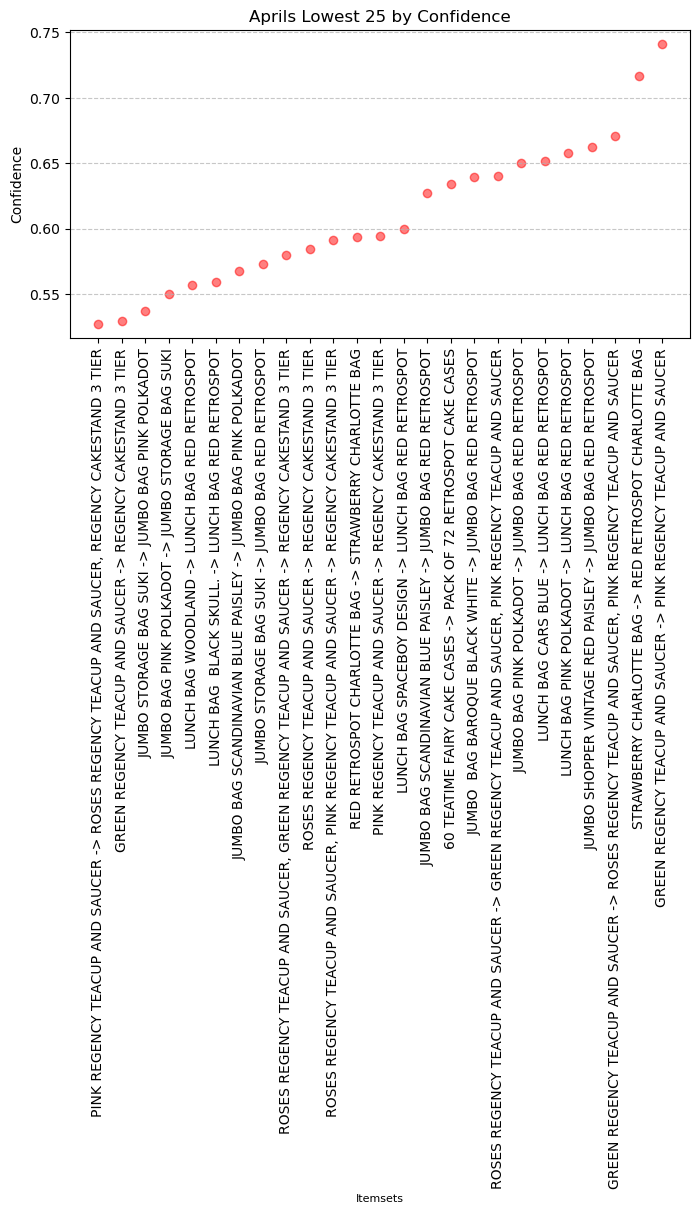

In [40]:
lowest_25_rules = rules.sort_values(by='confidence', ascending=True).head(25)

# Plot the lowest 25 rules by confidence
plt.figure(figsize=(8, 4))
plt.scatter(lowest_25_rules['itemsets'], lowest_25_rules['confidence'], color='red', alpha=0.5)
plt.xlabel('Itemsets', fontsize=8)
plt.ylabel('Confidence')
plt.title('Aprils Lowest 25 by Confidence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

In [41]:
rules.sort_values(by="lift", ascending=False)[:11]

,antecedents,consequents,support,confidence,lift,itemsets
23,(RED RETROSPOT CHARLOTTE BAG),(STRAWBERRY CHARLOTTE BAG),0.030135,0.593750,14.126769,RED RETROSPOT CHARLOTTE BAG -> STRAWBERRY CHAR...
22,(STRAWBERRY CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),0.030135,0.716981,14.126769,STRAWBERRY CHARLOTTE BAG -> RED RETROSPOT CHAR...
27,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.045202,0.826087,14.076968,"ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
28,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.045202,0.770270,14.076968,PINK REGENCY TEACUP AND SAUCER -> ROSES REGENC...
26,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.045202,0.904762,12.819155,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ..."
29,(ROSES REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.045202,0.640449,12.819155,ROSES REGENCY TEACUP AND SAUCER -> GREEN REGEN...
25,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.045202,0.863636,12.812299,"ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY ..."
30,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.045202,0.670588,12.812299,GREEN REGENCY TEACUP AND SAUCER -> ROSES REGEN...
37,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...",0.030928,0.527027,12.780405,PINK REGENCY TEACUP AND SAUCER -> ROSES REGENC...
34,"(ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...",(PINK REGENCY TEACUP AND SAUCER),0.030928,0.750000,12.780405,"ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKES..."


In [42]:
rules.sort_values(by="lift", ascending=True)[:11]

,antecedents,consequents,support,confidence,lift,itemsets
3,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.035686,0.529412,3.836714,GREEN REGENCY TEACUP AND SAUCER -> REGENCY CAK...
32,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(REGENCY CAKESTAND 3 TIER),0.031721,0.579710,4.201233,"ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
24,(ROSES REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.041237,0.584270,4.234276,ROSES REGENCY TEACUP AND SAUCER -> REGENCY CAK...
35,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(REGENCY CAKESTAND 3 TIER),0.030928,0.590909,4.282393,"ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY ..."
19,(PINK REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.034893,0.594595,4.309102,PINK REGENCY TEACUP AND SAUCER -> REGENCY CAKE...
13,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.037272,0.573171,5.973292,JUMBO STORAGE BAG SUKI -> JUMBO BAG RED RETROSPOT
18,(LUNCH BAG WOODLAND),(LUNCH BAG RED RETROSPOT),0.030928,0.557143,6.386883,LUNCH BAG WOODLAND -> LUNCH BAG RED RETROSPOT
14,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.030135,0.558824,6.406150,LUNCH BAG BLACK SKULL. -> LUNCH BAG RED RETRO...
11,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG RED RETROSPOT),0.033307,0.626866,6.532873,JUMBO BAG SCANDINAVIAN BLUE PAISLEY -> JUMBO B...
6,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.030928,0.639344,6.662918,JUMBO BAG BAROQUE BLACK WHITE -> JUMBO BAG RE...


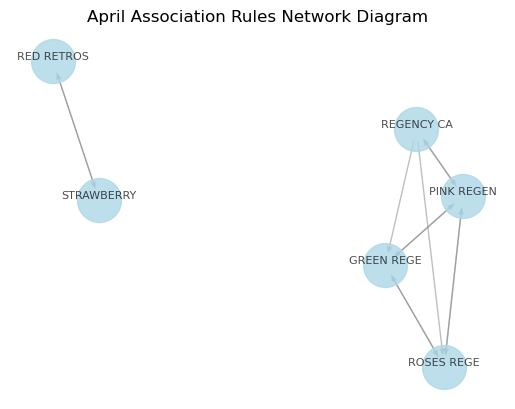

In [43]:
# Creating a threshold to get the top listed by "lift"
threshold_lift = 9
filtered_rules = rules[rules['lift'] >= threshold_lift]

# Create a directed graph
G = nx.DiGraph()

# Add nodes for antecedents and consequents
for _, row in filtered_rules.iterrows():
    for item in row['antecedents']:
        G.add_node(item)
    for item in row['consequents']:
        G.add_node(item)

# Add edges between antecedents and consequents
for _, row in filtered_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent)

# Set positions for nodes
pos = nx.spring_layout(G, scale=1000, k=1/len(G)**.1)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1, arrowsize=8, alpha=0.5)

# Add labels with adjusted positioning
nx.draw_networkx_labels(G, pos, labels={node: node[:10] for node in G.nodes()}, font_size=8, font_family='sans-serif', alpha=0.7, verticalalignment='bottom')

# Display the plot
plt.title('April Association Rules Network Diagram')
plt.axis('off')
plt.show()

C:\Users\alons\AppData\Local\Temp\ipykernel_14324\185002472.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


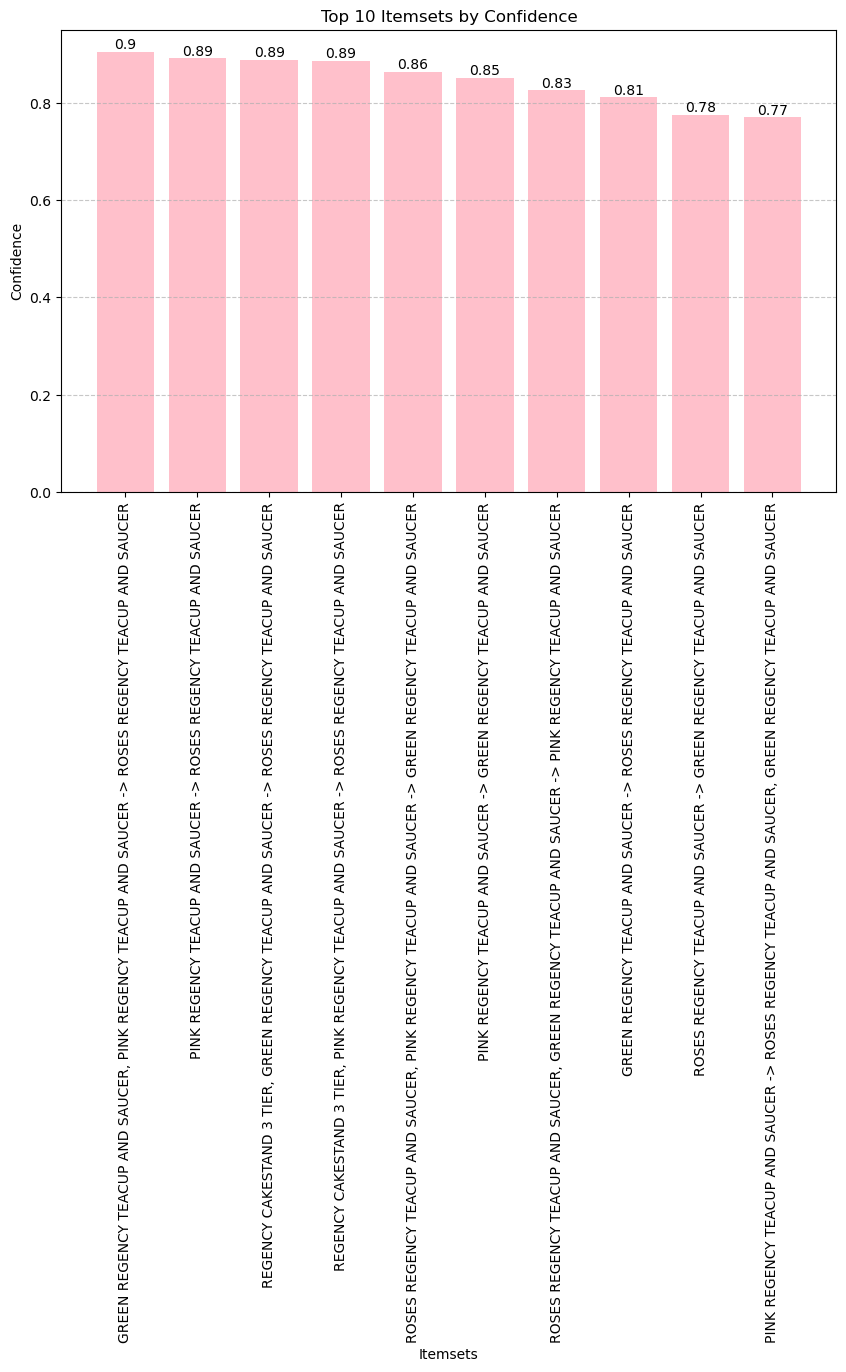

In [44]:
top_n_itemsets= rules.sort_values(by='confidence', ascending=False).head(10)
plt.figure(figsize=(10, 6))
bars = plt.bar(top_n_itemsets['itemsets'], top_n_itemsets['confidence'], color='pink')

# Annotating each bar with its confidence value
for i in range(len(bars)):
    plt.text(bars[i].get_x() + bars[i].get_width()/2, bars[i].get_height(), round(top_n_itemsets['confidence'].iloc[i], 2), 
             ha='center', va='bottom')

plt.title(f'Top 10 Itemsets by Confidence')
plt.xlabel('Itemsets')
plt.ylabel('Confidence')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\alons\AppData\Local\Temp\ipykernel_14324\1103170211.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


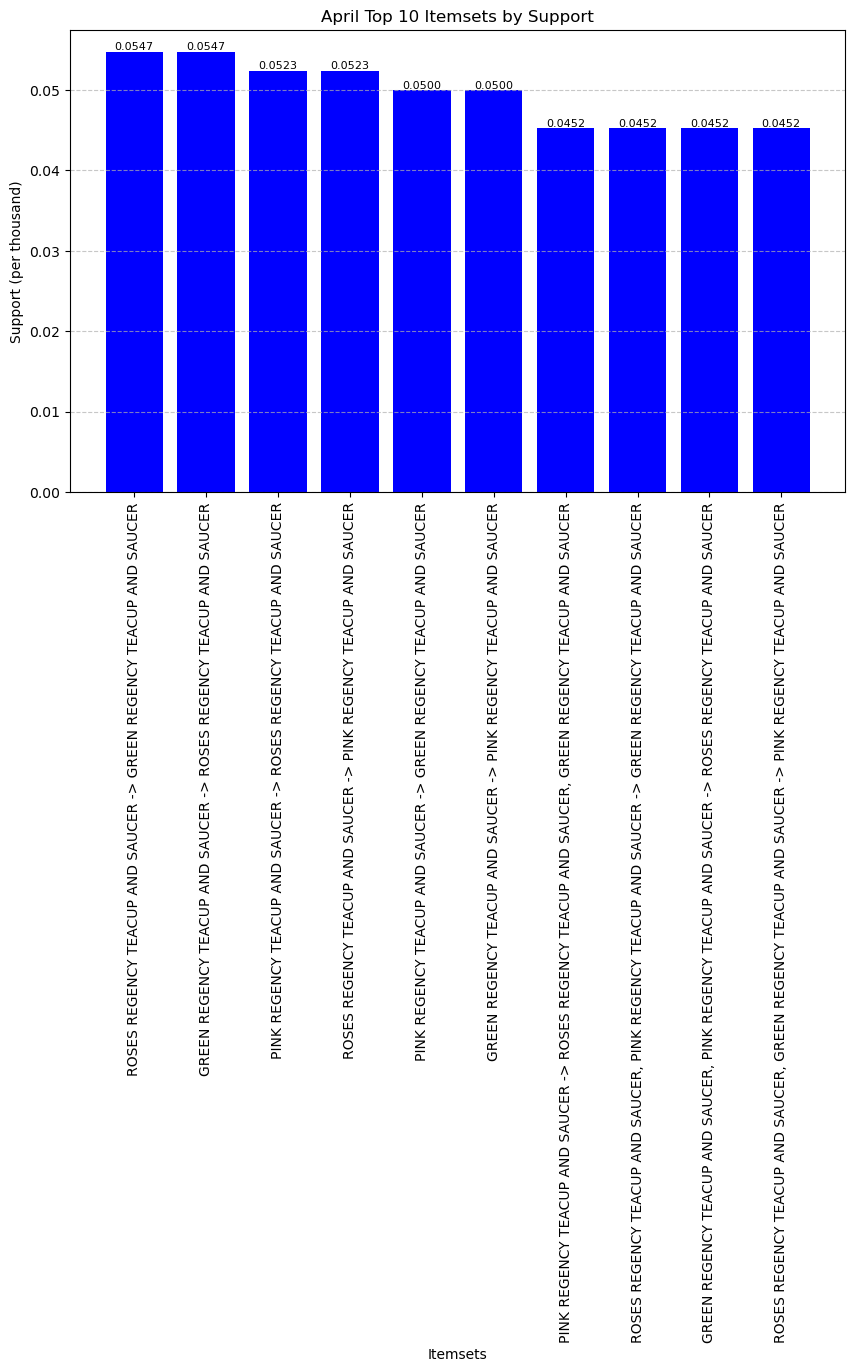

In [45]:
top_n_itemsets = rules.sort_values(by='support', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_n_itemsets['itemsets'], top_n_itemsets['support'], color='blue')

# Add confidence values as text labels above each bar
for bar, support in zip(bars, top_n_itemsets['support']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{support * 1:.4f}', 
             ha='center', va='bottom', color='black', fontsize=8)

plt.title('April Top 10 Itemsets by Support')
plt.xlabel('Itemsets')
plt.ylabel('Support (per thousand)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()